# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

state = np.random.RandomState(42)

### Общая информация о датасетах и проверка на дубликаты

Посмотрим, как выглядят датасеты и типы данных в их столбцах:

In [2]:
f = pd.read_csv('/datasets/geo_data_0.csv')
display(f.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [3]:
f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [4]:
f.duplicated().sum()

0

In [5]:
s = pd.read_csv('/datasets/geo_data_1.csv')
display(s.head())

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [6]:
s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
s.duplicated().sum()

0

In [8]:
t = pd.read_csv('/datasets/geo_data_2.csv')
display(t.head())

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [9]:
t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [10]:
t.duplicated().sum()

0

Вывод: в каждом датасете по 100000 строк, нет дубликатов и установлен верный формат данных в столбцах.

### Исследовательский анализ данных

Посмотрим распределение данных:

In [11]:
numeric_columns = ['f0', 'f1', 'f2', 'product']

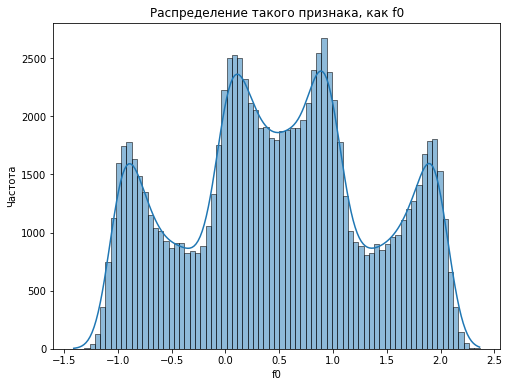

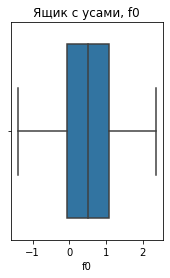

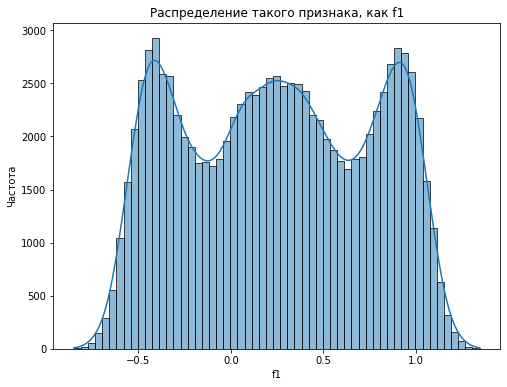

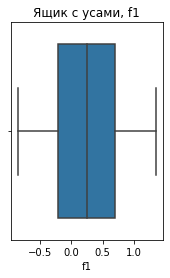

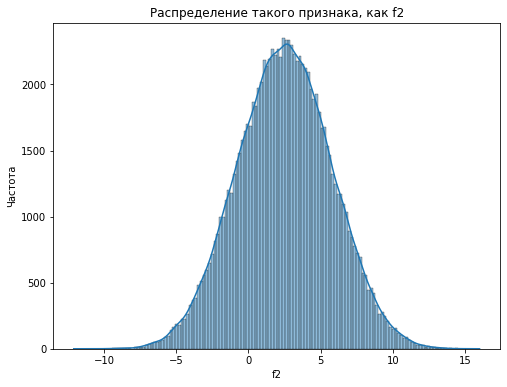

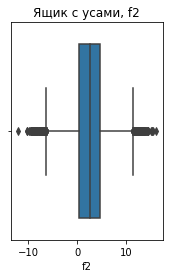

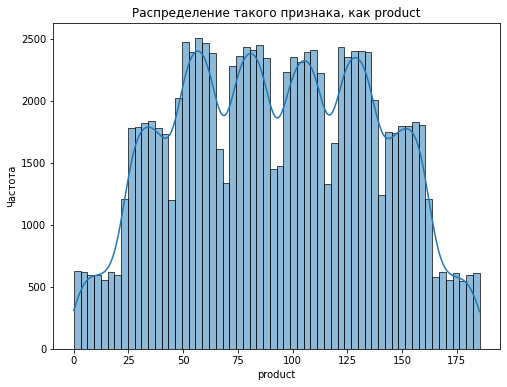

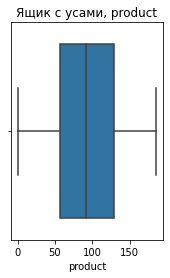

In [12]:
for column in numeric_columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(f[column], kde=True)
    plt.title(f'Распределение такого признака, как {column}')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.show()
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x=f[column])
    plt.title(f'Ящик с усами, {column}')
    plt.xlabel(column)
    
    plt.show()

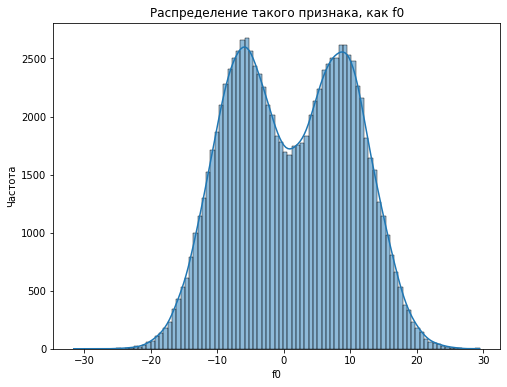

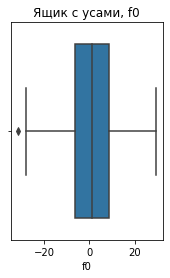

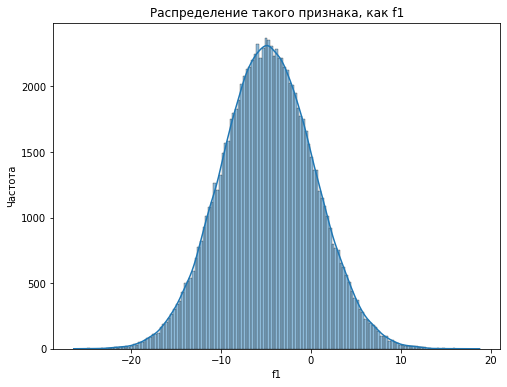

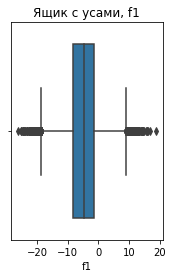

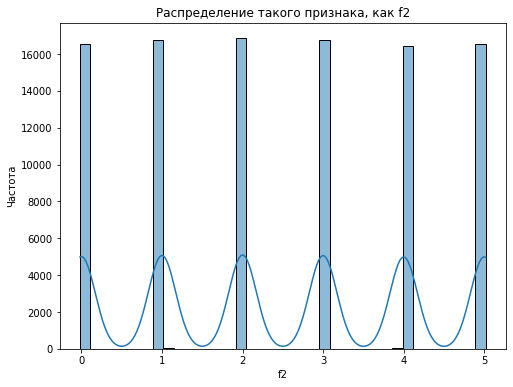

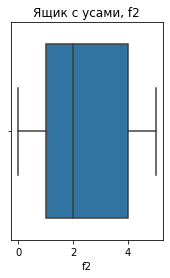

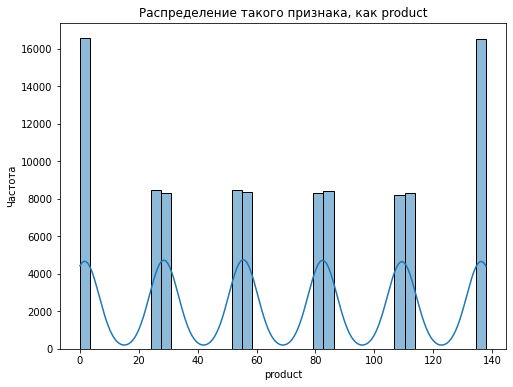

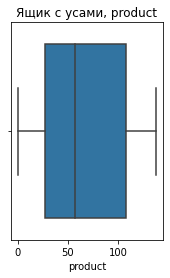

In [13]:
for column in numeric_columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(s[column], kde=True)
    plt.title(f'Распределение такого признака, как {column}')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.show()
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x=s[column])
    plt.title(f'Ящик с усами, {column}')
    plt.xlabel(column)
    
    plt.show()

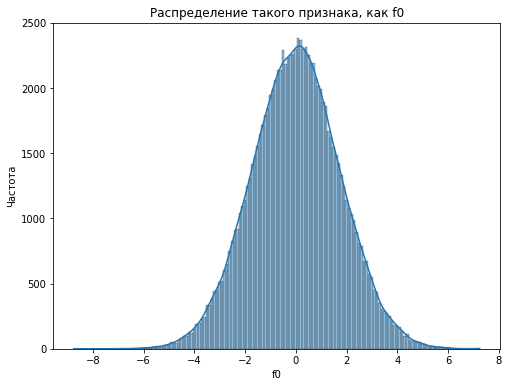

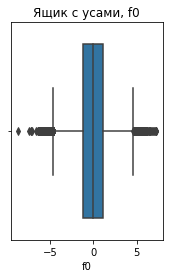

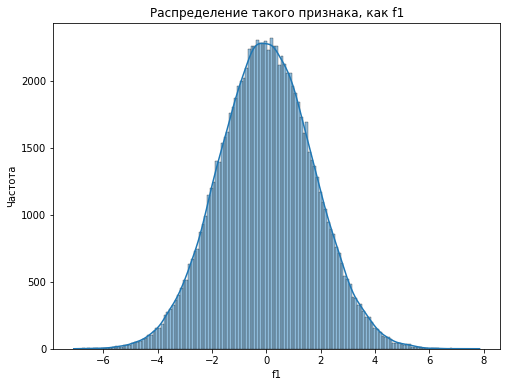

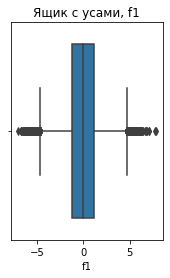

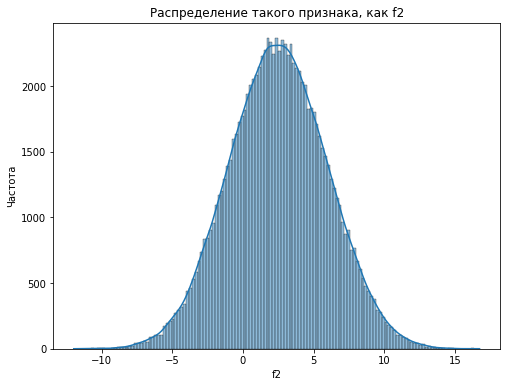

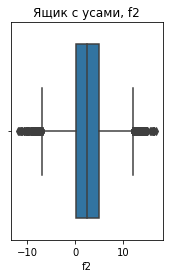

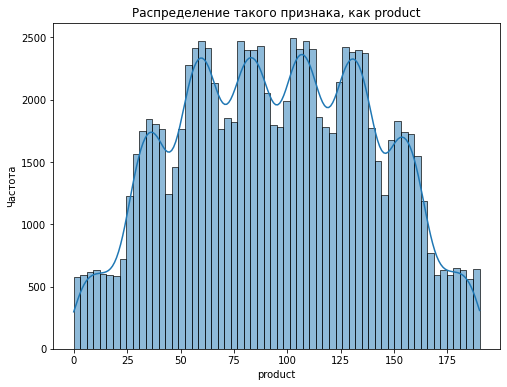

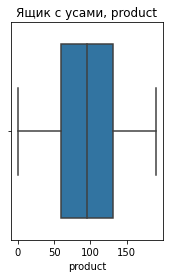

In [14]:
for column in numeric_columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(t[column], kde=True)
    plt.title(f'Распределение такого признака, как {column}')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.show()
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x=t[column])
    plt.title(f'Ящик с усами, {column}')
    plt.xlabel(column)
    
    plt.show()

Вывод: распределение данных в преимущественном большинстве ненормальное, в столбцах с признаками есть выбросы. Выбросы обрабатывать возможности и необходимости нет: признаки закодированы, и то, что значения не распределны по правилу трех сигм, не говорит о том, что они неверны, ведь это могут быть вполне реальные данные.

### Корреляционный анализ данных

Так как распределение данных ненормальное, для построения корреляционных матриц будем использовать коэффициент корреляции Спирмена:

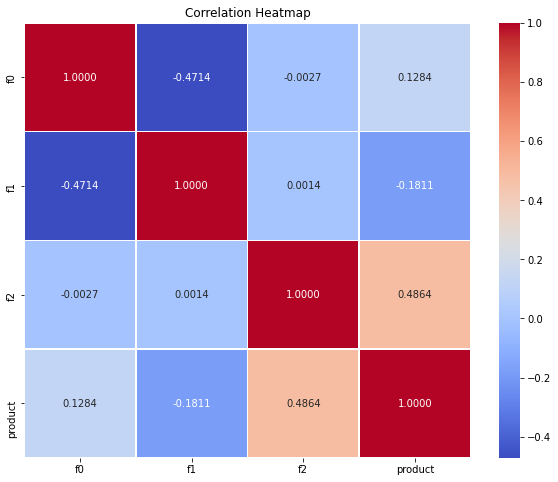

In [17]:
correlation_matrix = f.corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".4f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

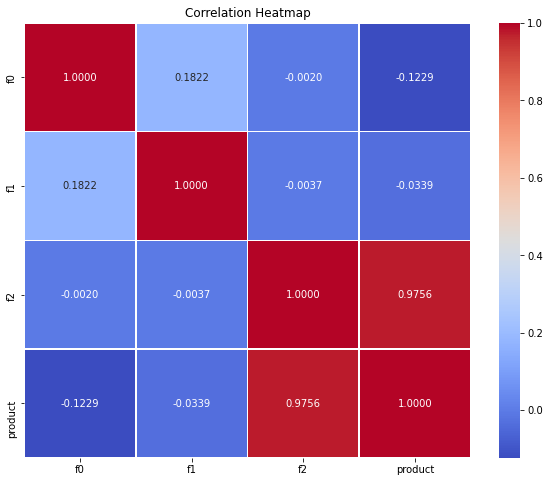

In [18]:
correlation_matrix = s.corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".4f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

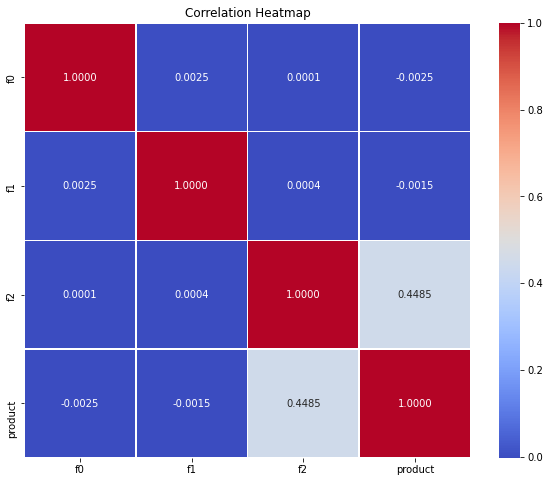

In [19]:
correlation_matrix = t.corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".4f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

Как видно из корреляционных матриц, в преимущественном большинстве между входными и целевым признаками есть слабая положительая линейная взаимосвязь. Мультиколлинеарности не нанблюдается, можно переходить к этапу обучения моделей!

## Обучение и проверка модели

In [20]:
def train_and_evaluate(data):
    """
    Функция берет на вход датасет.
    
    Оставляет только нужные признаки,
    Делит df на train и test, шкалирует.
    
    Обучает линейную модель
    
    Возвращает tuple с предсказаниями, labelы, RMSE
    """
    
    features = data.drop(['id', 'product'], axis=1)
    target = data['product']
    features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                                  target, 
                                                                                  test_size=0.25, 
                                                                                  random_state=1)
    scaler = MinMaxScaler()
    features_train = scaler.fit_transform(features_train)
    features_valid = scaler.transform(features_valid)
    
    lr = LinearRegression(normalize=False)
    lr.fit(features_train, target_train)
    predictions = lr.predict(features_valid)
    predictions = pd.Series(predictions)
    rmse = (mean_squared_error(predictions, target_valid))**(0.5)
    average_product = sum(predictions) / len(predictions)
    
    print("RMSE: {0:.2f}".format(rmse))
    print("Average product: {0:.2f}".format(average_product))
    
    return (predictions, target_valid.reset_index(drop=True), rmse)

In [21]:
print('Для первого региона:')
predictions_1, validation_1, rmse_1 = train_and_evaluate(f)
print('\nДля второго региона:')
predictions_2, validation_2, rmse_2 = train_and_evaluate(s)
print('\nДля третьего региона:')
predictions_3, validation_3, rmse_3 = train_and_evaluate(t)

Для первого региона:
RMSE: 37.74
Average product: 92.49

Для второго региона:
RMSE: 0.89
Average product: 69.12

Для третьего региона:
RMSE: 39.87
Average product: 94.96


## Подготовка к расчёту прибыли

In [23]:
BUDGET_PER_REGION = 10*(10**9)
PRE_MAX_POINTS = 500
FINAL_MAX_POINTS = 200
PRICE_PER_BARREL = 450000
DAMAGE_THRESHOLD =  0.025
NON_DAMAGE_VOLUME = (BUDGET_PER_REGION/(PRICE_PER_BARREL))/(FINAL_MAX_POINTS)
print("Достаточный объем сырья для безубыточной разработки новой скважины:", round(NON_DAMAGE_VOLUME, 3), "баррелей")

Достаточный объем сырья для безубыточной разработки новой скважины: 111.111 баррелей


In [24]:
f.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [25]:
s.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [26]:
t.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Таким образом, учитывая найденное значение точки безубыточности, которое превышает сердний запас сырья во всех трех регионах, необходимо провести Bootstrap для того, чтобы проанализировать прибыль и риски.

## Расчёт прибыли и рисков 

In [27]:
def profit(predictions, target):
    top_preds = predictions.sort_values(ascending=False)
    top_target = target[top_preds.index][:200]
    revenue = top_target.sum() * PRICE_PER_BARREL
    return revenue - BUDGET_PER_REGION

In [28]:
def conf_interval_and_loss_risk(predictions, target):
    revenue = []
    for _ in range(1000):
        target_sample = target.sample(500, replace=True, random_state=state)
        predictions_sample = predictions[target_sample.index]
        revenue.append(profit(predictions_sample, target_sample))   # ПОДСТАВИЛ НОВУЮ ФУНКЦИЮ profit_1
        
    lower = int(np.percentile(revenue, 2.5))
    higher = int(np.percentile(revenue, 97.5))
    mean_revenue = int(sum(revenue) / len(revenue))
    risk = st.percentileofscore(revenue, 0)

    return ((lower, higher), mean_revenue, risk)

In [29]:
i = 1
for preds, target in zip([predictions_1, predictions_2, predictions_3], 
                         [validation_1, validation_2, validation_3]):
    interval, mean_revenue, risk = conf_interval_and_loss_risk(preds, target)
    print(f"\nRegion {i}:")
    print(f"Mean: {round(mean_revenue/1000, 2)} thousand")
    print(f"95% confidence interval: {interval}")
    print(f"Risk of loss: {risk}%")
    i+=1


Region 1:
Mean: 483620.02 thousand
95% confidence interval: (-54499686, 999922208)
Risk of loss: 3.2%

Region 2:
Mean: 541232.38 thousand
95% confidence interval: (99573508, 963619380)
Risk of loss: 1.1%

Region 3:
Mean: 408477.74 thousand
95% confidence interval: (-147436391, 964607821)
Risk of loss: 7.300000000000001%


После подсчета прибыли и рисков, а также доверительного интервала в 95%, можно сделать следующий вывод: наиболее подходящим для разработки месторождений является второй регион: относительно других регионов у него минимальный риск убытков и максимальная прибыль.

## Общий вывод

Во время работы над проектом был выполнен исследовательский анализ данных, который показал наличие статистических выбросов и ненормального распределения данных. Выбросы не были обработаны, так как они закодированы и неизвестно, что они значат, а также потому что реальные данные могут не укладываться в правило трех сигм.

После корреляционного анализа были обучены модели с предварительным масштабированием данных и выведены результаты среднего запаса сырья и среднеквадратичной ошибки.

На основе полученных данных была посчитана прибыль, доверительный инетрвал и риск убытков, выраженный в процентах (также для каждого региона). Был предложен наиболее перспективный регион для разработки месторождений.